# XGBoost with Combined Ligand + Protein Features

### Approach

We now combine:
- **Ligand features**: Morgan fingerprints (2048D)
- **Protein pocket features**: AA composition + properties (26D)

This gives us a richer representation of the protein-ligand complex that should improve binding affinity prediction.

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

### Load ligand features and labels

In [2]:
# Load the ligand data
DATA_DIR = "../data"
INTERIM_DIR = Path(DATA_DIR, "interim")
LIGAND_PATH = Path(INTERIM_DIR, "reg_preprocessed_1.npz")

ligand_data = np.load(LIGAND_PATH)
X_train_ligand = ligand_data["X_train"]
X_test_ligand = ligand_data["X_test"]
y_train = ligand_data["y_train"]
y_test = ligand_data["y_test"]
train_ids = ligand_data["train_ids"]
test_ids = ligand_data["test_ids"]

print(f"Ligand features - Train: {X_train_ligand.shape}, Test: {X_test_ligand.shape}")
print(f"Labels - Train: {y_train.shape}, Test: {y_test.shape}")

Ligand features - Train: (3509, 2048), Test: (195, 2048)
Labels - Train: (3509,), Test: (195,)


### Load protein pocket features

In [3]:
# Load the protein pocket features
POCKET_PATH = Path(INTERIM_DIR, "pocket_features.npz")

pocket_data = np.load(POCKET_PATH)
X_train_pocket = pocket_data["X_train_pockets"]
X_test_pocket = pocket_data["X_test_pockets"]
train_ids_pocket = pocket_data["train_ids_retained"]
test_ids_pocket = pocket_data["test_ids_retained"]

print(f"Pocket features - Train: {X_train_pocket.shape}, Test: {X_test_pocket.shape}")

Pocket features - Train: (3509, 26), Test: (195, 26)


### Align the datasets

Since some pockets may not have been successfully featurized, we need to filter the ligand features and labels to match only the IDs that have both ligand and pocket features.

In [11]:
# Create index mappings for alignment
def align_features(ligand_X, ligand_y, ligand_ids, pocket_X, pocket_ids):
    """
    Align ligand and pocket features based on matching IDs.
    Returns concatenated features and aligned labels.
    """
    # Convert to lists for easier indexing
    ligand_ids_list = list(ligand_ids)
    pocket_ids_list = list(pocket_ids)
    
    # Find common IDs and their indices
    aligned_ligand_X = []
    aligned_pocket_X = []
    aligned_y = []
    aligned_ids = []
    
    for i, pid in enumerate(pocket_ids_list):
        if pid in ligand_ids_list:
            lig_idx = ligand_ids_list.index(pid)
            aligned_ligand_X.append(ligand_X[lig_idx])
            aligned_pocket_X.append(pocket_X[i])
            aligned_y.append(ligand_y[lig_idx])
            aligned_ids.append(pid)
    
    # Concatenate ligand and pocket features
    X_combined = np.concatenate(
        [np.array(aligned_ligand_X), np.array(aligned_pocket_X)],
        axis=1
    )
    
    return X_combined, np.array(aligned_y), aligned_ids

# Align train and test sets
X_train_combined, y_train_aligned, train_ids_final = align_features(
    X_train_ligand, y_train, train_ids,
    X_train_pocket, train_ids_pocket
)

X_test_combined, y_test_aligned, test_ids_final = align_features(
    X_test_ligand, y_test, test_ids,
    X_test_pocket, test_ids_pocket
)

### Train XGBoost with combined features

In [14]:
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=45,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50
)

# Fit model with evaluation sets
model.fit(
    X_train_combined, y_train_aligned,
    eval_set=[(X_train_combined, y_train_aligned), (X_test_combined, y_test_aligned)],
    verbose=False
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


### As we can see, the model performs much better now. Pearson's R is up by 25%, while our test RMSE is down 19%, compared to the best iteraton without protein structures

In [15]:
# Get predictions
y_pred_train = model.predict(X_train_combined)
y_pred_test = model.predict(X_test_combined)

# Calculate metrics
train_r2 = r2_score(y_train_aligned, y_pred_train)
train_rmse = mean_squared_error(y_train_aligned, y_pred_train)

test_r2 = r2_score(y_test_aligned, y_pred_test)
test_rmse = mean_squared_error(y_test_aligned, y_pred_test)

pearson_r, p_value = pearsonr(y_test_aligned, y_pred_test)

print(f"Train R²: {train_r2:.3f}")
print(f"Train RMSE: {train_rmse:.3f}")
print()
print(f"Test  R²: {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")
print()
print(f"Pearson R: {pearson_r:.3f}")

Train R²: 0.608
Train RMSE: 0.043

Test  R²: 0.341
Test RMSE: 0.069

Pearson R: 0.586


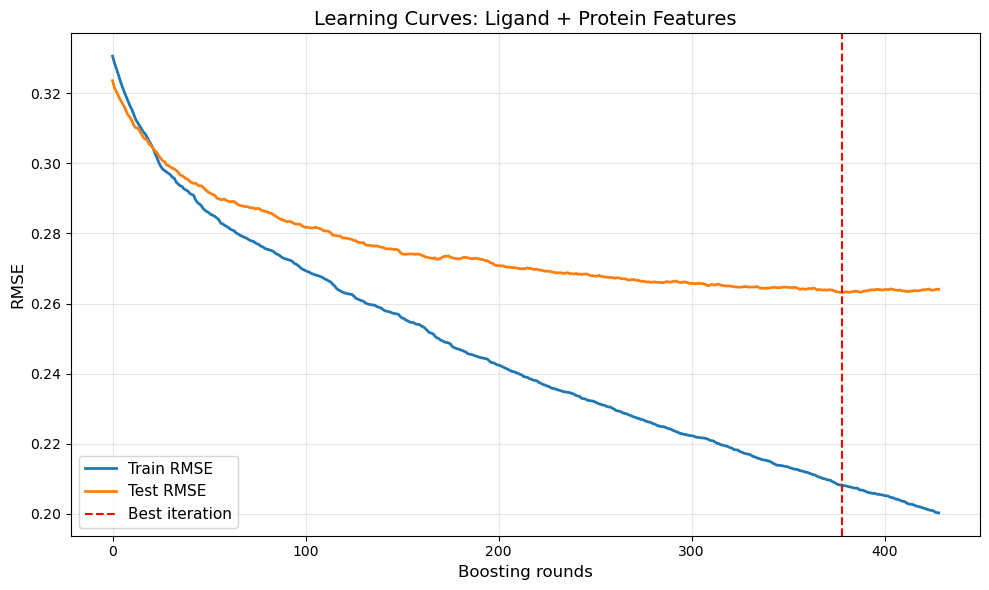

In [10]:
# Extract training history
evals_result = model.evals_result()

train_rmse = evals_result['validation_0']['rmse']
test_rmse = evals_result['validation_1']['rmse']

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Train RMSE', linewidth=2)
plt.plot(test_rmse, label='Test RMSE', linewidth=2)
plt.axvline(model.best_iteration, color='red', linestyle='--', label='Best iteration')
plt.xlabel('Boosting rounds', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend(fontsize=11)
plt.title('Learning Curves: Ligand + Protein Features', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()